In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict

In [3]:
from bokeh.plotting import figure, output_file, show

In [4]:
df = pd.read_csv('ACISDailyData-20170101-20190101-PID144512549.csv', parse_dates = True, index_col='Date (Local Standard Time)')
df.drop('Station Name', axis=1, inplace=True)

In [5]:
param_grid = {'C': [0.1,1,10,100], 'gamma':[1,0.1,0.01,0.0001]}

In [6]:
grid = GridSearchCV(SVR(), param_grid, cv=5, iid=False)

In [7]:
y = df['Wind Speed 2 m Avg. (km/h)']
X = df.drop('Wind Speed 2 m Avg. (km/h)', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [9]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
grid.best_estimator_

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [11]:
predictions = grid.predict(X_test)

In [12]:
np.sqrt(mse(y_test, predictions))

4.83365810987608

In [13]:
df['predictedsvr'] = grid.predict(X)

In [14]:
cv_scores = []
for i in range(1,40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = cross_val_predict(knn, X_train, y_train, cv=10)
    cv_scores.append(np.sqrt(mse(y_train, pred_i)))

Text(0,0.5,'Error Rate')

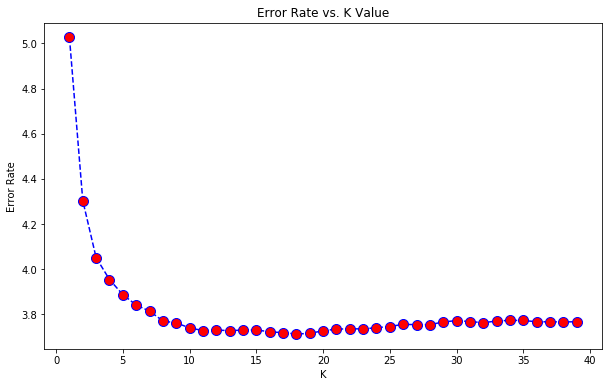

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),cv_scores,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [16]:
knn = KNeighborsRegressor(n_neighbors=16)
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=16, p=2,
          weights='uniform')

In [17]:
knn_pred = knn.predict(X_test)

In [18]:
np.sqrt(mse(y_test, knn_pred))

4.745463515126873

In [19]:
df['predictedknn'] = knn.predict(X)

In [20]:
p = figure(width = 500, height = 250, x_axis_type = "datetime", sizing_mode='scale_both')
p.line(df.index, df['Wind Speed 2 m Avg. (km/h)'], line_width = 2, color = "Blue", alpha = 1, legend='Actual')
p.line(df.index, df['predictedsvr'], line_width = 2, color = "Orange", alpha = 0.5, legend='SVR Predicted')
p.line(df.index, df['predictedknn'], line_width = 2, color = "Red", alpha = 0.5, legend='kNN Predicted')

p.legend.location = "top_left"
p.legend.click_policy="hide"
output_file('windmodels.html')
show(p)